In [11]:
%%writefile train_lora.py

from google.colab import drive
drive.mount('/content/drive')
!pip install -q torch==2.9.1 torchvision==0.24.1 torchaudio==2.9.1 --index-url https://download.pytorch.org/whl/cu126
!pip install -q xformers==0.0.33.post2 accelerate transformers bitsandbytes datasets ftfy
!git clone https://github.com/huggingface/diffusers.git
!pip install -e ./diffusers
!pip install mediapipe

from accelerate.utils import write_basic_config
write_basic_config()

print("Environment Ready")

import os
from PIL import Image, ImageOps

INPUT_FOLDER = "/content/drive/MyDrive/training_images"
OUTPUT_FOLDER = "/content/drive/MyDrive/training_images_padded"

if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
processed_count = 0

for filename in os.listdir(INPUT_FOLDER):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
        try:
            img_path = os.path.join(INPUT_FOLDER, filename)
            img = Image.open(img_path).convert("RGB")
            img.thumbnail((512, 512), Image.Resampling.LANCZOS)
            background = Image.new("RGB", (512, 512), (0, 0, 0))
            x_offset = (512 - img.width) // 2
            y_offset = (512 - img.height) // 2
            background.paste(img, (x_offset, y_offset))
            save_path = os.path.join(OUTPUT_FOLDER, filename)
            background.save(save_path, quality=100)
            processed_count += 1

        except Exception as e:
            print(f"Error on {filename}: {e}")

print(f"\nPadded images.")

import os
import json
from PIL import Image


IMAGES_FOLDER = "/content/drive/MyDrive/training_images_padded"
TRIGGER_WORD = "levi_training_model"

metadata_path = os.path.join(IMAGES_FOLDER, "metadata.jsonl")

image_tags = {
    # Bloody/Combat scenes
    "Bloody3.jpg": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, blood on face, reverse grip, holding sword, profile, lowered view, intense expression, serious",
    "Bloody1.jpg": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, dual wielding, reverse grip, holding swords, action pose, looking at camera, dynamic angle, mid air, blood on face, injured, intense expression",
    "Bloody2.jpg": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, blood on face, injured, standing, looking at viewer, serious",

    # Generic/Standard Survey Corps Uniform
    "Generic1.jpg": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, white cravat, view from the side, standing, hands at sides, serious",
    "Generic2.jpg": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, white cravat, white pants, standing, looking at viewer, hands at sides, serious",
    "Generic3.jpg": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, profile, view from side, looking away, standing, serious",
    "Generic4.jpeg": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, white cravat, profile, view from side, looking away, standing, serious",
    "Generic5.png": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, standing, looking to the side, hands at sides, serious",
    "Generic6.jpg": "black hair, undercut, gray eyes, male focus, angry, screaming, survey corps uniform, green cape, white cravat, looking at viewer, standing, hands at sides, open mouth",

    # Combat/Sword poses
    "GenericSword1.jpg": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, white pants, 3d maneuvering gear, dual wielding, reverse grip, holding swords, action pose, facing camera, dynamic angle, mid air, serious",
    "GenericSword2.jpg": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, white cravat, reverse grip, unsheathing sword, combat pose, looking at viewer, serious",

    # Formal/Suit outfits
    "Suit1.jpg": "black hair, undercut, gray eyes, male focus, black suit, white shirt, formal wear, black pants, looking to the side, sitting on chair, serious",
    "Suit2.jpg": "black hair, undercut, gray eyes, male focus, black suit, white shirt, formal wear, looking at viewer, standing, serious",
    "Suit3.jpg": "black hair, undercut, gray eyes, male focus, black suit, white shirt, formal wear, looking at viewer, sitting, view from side, serious",
    "Suit4.jpg": "black hair, undercut, gray eyes, male focus, black suit, white shirt, formal wear, view from side, looking down, obscured eyes, sitting, serious",

    # Casual/Shirt only (no jacket)
    "Shirt1.jpg": "black hair, undercut, gray eyes, male focus, survey corps uniform, brown jacket, no cape, white cravat, looking at viewer, serious",
    "Shirt2.jpg": "black hair, undercut, gray eyes, male focus, white shirt, rolled sleeves, looking at viewer, standing, arms raised in front, view from side, serious",
    "Shirt3.jpg": "black hair, undercut, gray eyes, male focus, white shirt, dual wielding, reverse grip, holding swords, looking at the side, view from side, mid air, 3d maneuvering gear, serious",
    "Shirt4.jpg": "black hair, undercut, gray eyes, male focus, white shirt, looking at viewer, view from side, mid air, serious",
    "Shirt5.jpeg": "black hair, undercut, gray eyes, male focus, white shirt, view from side, looking to the side, standing, serious",
    "Shirt6.jpg": "black hair, undercut, gray eyes, male focus, white shirt, looking at viewer, sitting on chair, view from side, serious",
    "Shirt7.jpg": "black hair, undercut, gray eyes, male focus, white shirt, profile, side view, standing, serious",
    "Shirt8.jpg": "black hair, undercut, gray eyes, male focus, white shirt, looking to the side, elevated view, serious",

    # No cape/minimal uniform
    "NoCape1.jpg": "black hair, undercut, gray eyes, male focus, white shirt, white cravat, looking at ahead, elevated view, serious",
    "NoCape2.jpg": "black hair, undercut, gray eyes, male focus, white shirt, rolled sleeves, white cravat, hands with towel, looking at viewer, view from side, standing, serious",
}

valid_images = []
print(f"Scanning {IMAGES_FOLDER}")

if not os.path.exists(IMAGES_FOLDER):
    print(f"Padded folder not found")
else:
    for filename in os.listdir(IMAGES_FOLDER):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".webp")):
            try:
                path = os.path.join(IMAGES_FOLDER, filename)
                with Image.open(path) as img:
                    img.verify()
                description = image_tags.get(
                    filename,
                    "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, serious"
                )
                full_text = f"{TRIGGER_WORD}, {description}"

                entry = {"file_name": filename, "text": full_text}
                valid_images.append(json.dumps(entry))
                print(f"Mapped: {filename}")

            except Exception as e:
                print(f"Bad file {filename}: {e}")

    if len(valid_images) > 0:
        with open(metadata_path, "w") as f:
            for line in valid_images:
                f.write(line + "\n")
        print(f"\nMetadata saved ")
    else:
        print("No valid images found.")

import os
import shutil

SOURCE_DIR = "/content/drive/MyDrive/training_images_padded"
LOCAL_DIR = "/content/local_train_data"
OUTPUT_DIR = "/content/drive/MyDrive/my_first_lora_output_v5"


if os.path.exists(LOCAL_DIR):
    shutil.rmtree(LOCAL_DIR)
shutil.copytree(SOURCE_DIR, LOCAL_DIR)
print(f"Copied to {LOCAL_DIR}")


os.environ["MODEL_NAME"] = "runwayml/stable-diffusion-v1-5"
os.environ["OUTPUT_DIR"] = OUTPUT_DIR
os.environ["DATA_DIR"] = LOCAL_DIR

!accelerate launch /content/diffusers/examples/text_to_image/train_text_to_image_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --train_data_dir=$DATA_DIR \
  --dataloader_num_workers=0 \
  --resolution=512 \
  --center_crop \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=900 \
  --learning_rate=1.5e-04 \
  --max_grad_norm=1 \
  --lr_scheduler="cosine" \
  --lr_warmup_steps=0 \
  --output_dir=$OUTPUT_DIR \
  --rank=32 \
  --checkpointing_steps=150 \
  --seed=1337 \
  --mixed_precision="fp16"

import torch
import os
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
from PIL import Image
from IPython.display import display

CHECKPOINT_STEP = 600
OUTPUT_DIR = "/content/drive/MyDrive/my_first_lora_output_v5"

LORA_SCALE = 0.9
NUM_IMAGES = 2
GUIDANCE_SCALE = 7.0
INFERENCE_STEPS = 30

ENABLE_HIRES_FIX = True
HIRES_STRENGTH = 0.35
UPSCALE_FACTOR = 1.5

model_folder = os.path.join(OUTPUT_DIR, f"checkpoint-{CHECKPOINT_STEP}")

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False
).to("cuda")

pipe.load_lora_weights(model_folder, weight_name="pytorch_lora_weights.safetensors")

refiner = StableDiffusionImg2ImgPipeline(**pipe.components)

def image_grid(imgs, rows, cols):
    w, h = imgs[0].size
    grid = Image.new('RGB', (cols*w, rows*h))
    for i, img in enumerate(imgs):
        grid.paste(img, (i%cols*w, i//cols*h))
    return grid

prompt = (
"levi_training_model, black hair, undercut, gray eyes, male focus, black suit, white shirt, formal wear, looking at viewer, sitting, view from side, serious, highly detailed eyes, sharp focus"
)

neg_prompt = (
    "shiny eyes, glossy eyes, wet eyes, reflective eyes, eye shine, "
    "bad anatomy, poorly drawn eyes, ugly eyes, lowres, blurry, bad quality"
)

print(f"\nGenerating Base Images...")


base_images = pipe(
    prompt,
    negative_prompt=neg_prompt,
    num_inference_steps=INFERENCE_STEPS,
    guidance_scale=GUIDANCE_SCALE,
    cross_attention_kwargs={"scale": LORA_SCALE},
    num_images_per_prompt=NUM_IMAGES,
    height=512, width=512
).images

final_images = base_images

if ENABLE_HIRES_FIX:
    print(f"Running Hires...")
    hires_images = []

    for img in base_images:
        w, h = img.size
        new_w, new_h = int(w * UPSCALE_FACTOR), int(h * UPSCALE_FACTOR)
        upscaled_img = img.resize((new_w, new_h), resample=Image.LANCZOS)

        refined_img = refiner(
            prompt=prompt,
            negative_prompt=neg_prompt,
            image=upscaled_img,
            num_inference_steps=30,
            strength=HIRES_STRENGTH,
            guidance_scale=GUIDANCE_SCALE,
            cross_attention_kwargs={"scale": LORA_SCALE}
        ).images[0]
        hires_images.append(refined_img)

    final_images = hires_images

grid = image_grid(final_images, rows=1, cols=NUM_IMAGES)
display(grid)

print("\nGeneration complete!")

Writing train_lora.py


In [15]:
# This saves the current notebook state to a file in your local Colab directory
import json
import os

# Get the name of your notebook (usually 'Untitled0.ipynb' if not renamed)
# If you renamed it, change 'Untitled0.ipynb' to your actual name
notebook_path = '/content/drive/MyDrive/Colab Notebooks/Untitled0.ipynb'

# If you aren't sure where it is, this command copies the one you are currently in:
!cp "/content/drive/MyDrive/Colab Notebooks/Untitled0.ipynb" ./LoRA_Training_Experiment.ipynb

cp: cannot stat '/content/drive/MyDrive/Colab Notebooks/Untitled0.ipynb': No such file or directory


In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -q torch==2.9.1 torchvision==0.24.1 torchaudio==2.9.1 --index-url https://download.pytorch.org/whl/cu126
!pip install -q xformers==0.0.33.post2 accelerate transformers bitsandbytes datasets ftfy
!git clone https://github.com/huggingface/diffusers.git
!pip install -e ./diffusers
!pip install mediapipe

from accelerate.utils import write_basic_config
write_basic_config()

print("Environment Ready")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'diffusers' already exists and is not an empty directory.
Obtaining file:///content/diffusers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for diffusers (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.37.0.dev0-0.editable-py3-none-any.whl size=11375 sha256=e7f1f1d65c02638c712f057fcfdac4d6717336ca6bd195098b6a488b584f8b1b
  Stored in directory: /tmp/pip-ephem-wheel-cache-yo2oaj4m/wheels/8a/fc/09/385efb77b455b2fd4a656c950079c93147e1f50ae614e51beb
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.37.0.dev0
    Uninstalling diffusers-0.37.0.dev0:
      Successfully uninstall

In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [ ]:
import os
from PIL import Image, ImageOps

INPUT_FOLDER = "/content/drive/MyDrive/training_images"
OUTPUT_FOLDER = "/content/drive/MyDrive/training_images_padded"

if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
processed_count = 0

for filename in os.listdir(INPUT_FOLDER):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
        try:
            img_path = os.path.join(INPUT_FOLDER, filename)
            img = Image.open(img_path).convert("RGB")
            img.thumbnail((512, 512), Image.Resampling.LANCZOS)
            background = Image.new("RGB", (512, 512), (0, 0, 0))
            x_offset = (512 - img.width) // 2
            y_offset = (512 - img.height) // 2
            background.paste(img, (x_offset, y_offset))
            save_path = os.path.join(OUTPUT_FOLDER, filename)
            background.save(save_path, quality=100)
            processed_count += 1

        except Exception as e:
            print(f"Error on {filename}: {e}")

print(f"\nPadded images.")

🖼️ Processing images from /content/drive/MyDrive/training_images...
💾 Saving padded versions to /content/drive/MyDrive/training_images_padded...

✅ Done! Padded 25 images.
👉 You can now use these images for training. The swords will be visible!


In [ ]:
import os
import json
from PIL import Image


IMAGES_FOLDER = "/content/drive/MyDrive/training_images_padded"
TRIGGER_WORD = "levi_training_model"

metadata_path = os.path.join(IMAGES_FOLDER, "metadata.jsonl")

image_tags = {
    # Bloody/Combat scenes
    "Bloody3.jpg": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, blood on face, reverse grip, holding sword, profile, lowered view, intense expression, serious",
    "Bloody1.jpg": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, dual wielding, reverse grip, holding swords, action pose, looking at camera, dynamic angle, mid air, blood on face, injured, intense expression",
    "Bloody2.jpg": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, blood on face, injured, standing, looking at viewer, serious",

    # Generic/Standard Survey Corps Uniform
    "Generic1.jpg": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, white cravat, view from the side, standing, hands at sides, serious",
    "Generic2.jpg": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, white cravat, white pants, standing, looking at viewer, hands at sides, serious",
    "Generic3.jpg": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, profile, view from side, looking away, standing, serious",
    "Generic4.jpeg": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, white cravat, profile, view from side, looking away, standing, serious",
    "Generic5.png": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, standing, looking to the side, hands at sides, serious",
    "Generic6.jpg": "black hair, undercut, gray eyes, male focus, angry, screaming, survey corps uniform, green cape, white cravat, looking at viewer, standing, hands at sides, open mouth",

    # Combat/Sword poses
    "GenericSword1.jpg": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, white pants, 3d maneuvering gear, dual wielding, reverse grip, holding swords, action pose, facing camera, dynamic angle, mid air, serious",
    "GenericSword2.jpg": "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, white cravat, reverse grip, unsheathing sword, combat pose, looking at viewer, serious",

    # Formal/Suit outfits
    "Suit1.jpg": "black hair, undercut, gray eyes, male focus, black suit, white shirt, formal wear, black pants, looking to the side, sitting on chair, serious",
    "Suit2.jpg": "black hair, undercut, gray eyes, male focus, black suit, white shirt, formal wear, looking at viewer, standing, serious",
    "Suit3.jpg": "black hair, undercut, gray eyes, male focus, black suit, white shirt, formal wear, looking at viewer, sitting, view from side, serious",
    "Suit4.jpg": "black hair, undercut, gray eyes, male focus, black suit, white shirt, formal wear, view from side, looking down, obscured eyes, sitting, serious",

    # Casual/Shirt only (no jacket)
    "Shirt1.jpg": "black hair, undercut, gray eyes, male focus, survey corps uniform, brown jacket, no cape, white cravat, looking at viewer, serious",
    "Shirt2.jpg": "black hair, undercut, gray eyes, male focus, white shirt, rolled sleeves, looking at viewer, standing, arms raised in front, view from side, serious",
    "Shirt3.jpg": "black hair, undercut, gray eyes, male focus, white shirt, dual wielding, reverse grip, holding swords, looking at the side, view from side, mid air, 3d maneuvering gear, serious",
    "Shirt4.jpg": "black hair, undercut, gray eyes, male focus, white shirt, looking at viewer, view from side, mid air, serious",
    "Shirt5.jpeg": "black hair, undercut, gray eyes, male focus, white shirt, view from side, looking to the side, standing, serious",
    "Shirt6.jpg": "black hair, undercut, gray eyes, male focus, white shirt, looking at viewer, sitting on chair, view from side, serious",
    "Shirt7.jpg": "black hair, undercut, gray eyes, male focus, white shirt, profile, side view, standing, serious",
    "Shirt8.jpg": "black hair, undercut, gray eyes, male focus, white shirt, looking to the side, elevated view, serious",

    # No cape/minimal uniform
    "NoCape1.jpg": "black hair, undercut, gray eyes, male focus, white shirt, white cravat, looking at ahead, elevated view, serious",
    "NoCape2.jpg": "black hair, undercut, gray eyes, male focus, white shirt, rolled sleeves, white cravat, hands with towel, looking at viewer, view from side, standing, serious",
}

valid_images = []
print(f"Scanning {IMAGES_FOLDER}")

if not os.path.exists(IMAGES_FOLDER):
    print(f"Padded folder not found")
else:
    for filename in os.listdir(IMAGES_FOLDER):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".webp")):
            try:
                path = os.path.join(IMAGES_FOLDER, filename)
                with Image.open(path) as img:
                    img.verify()
                description = image_tags.get(
                    filename,
                    "black hair, undercut, gray eyes, male focus, survey corps uniform, green cape, serious"
                )
                full_text = f"{TRIGGER_WORD}, {description}"

                entry = {"file_name": filename, "text": full_text}
                valid_images.append(json.dumps(entry))
                print(f"Mapped: {filename}")

            except Exception as e:
                print(f"Bad file {filename}: {e}")

    if len(valid_images) > 0:
        with open(metadata_path, "w") as f:
            for line in valid_images:
                f.write(line + "\n")
        print(f"\nMetadata saved ")
    else:
        print("No valid images found.")

🔍 Scanning /content/drive/MyDrive/training_images_padded...
   ✓ Shirt8.jpg
   ✓ Generic2.jpg
   ✓ Suit4.jpg
   ✓ Generic1.jpg
   ✓ Shirt4.jpg
   ✓ Suit3.jpg
   ✓ Shirt2.jpg
   ✓ Shirt1.jpg
   ✓ Suit2.jpg
   ✓ Shirt6.jpg
   ✓ Generic4.jpeg
   ✓ Generic3.jpg
   ✓ Shirt7.jpg
   ✓ Shirt5.jpeg
   ✓ Suit1.jpg
   ✓ NoCape1.jpg
   ✓ Generic5.png
   ✓ NoCape2.jpg
   ✓ Generic6.jpg
   ✓ Bloody1.jpg
   ✓ Bloody3.jpg
   ✓ GenericSword2.jpg
   ✓ GenericSword1.jpg
   ✓ Shirt3.jpg
   ✓ Bloody2.jpg

✅ SOLID PUPILS METADATA SAVED!
📊 Images tagged: 25

🎯 EYE RENDERING IMPROVEMENTS:
   • 'solid pupils' added to EVERY image
   • 'defined eyes' added to EVERY image
   • Teaches model to render pupils as filled/solid
   • Should reduce white highlights washing out color

🚀 Ready to retrain with proper pupil rendering!


In [ ]:
import os
import shutil

SOURCE_DIR = "/content/drive/MyDrive/training_images_padded"
LOCAL_DIR = "/content/local_train_data"
OUTPUT_DIR = "/content/drive/MyDrive/my_first_lora_output_v5"


if os.path.exists(LOCAL_DIR):
    shutil.rmtree(LOCAL_DIR)
shutil.copytree(SOURCE_DIR, LOCAL_DIR)
print(f"Copied to {LOCAL_DIR}")


os.environ["MODEL_NAME"] = "runwayml/stable-diffusion-v1-5"
os.environ["OUTPUT_DIR"] = OUTPUT_DIR
os.environ["DATA_DIR"] = LOCAL_DIR

!accelerate launch /content/diffusers/examples/text_to_image/train_text_to_image_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --train_data_dir=$DATA_DIR \
  --dataloader_num_workers=0 \
  --resolution=512 \
  --center_crop \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=900 \
  --learning_rate=1.5e-04 \
  --max_grad_norm=1 \
  --lr_scheduler="cosine" \
  --lr_warmup_steps=0 \
  --output_dir=$OUTPUT_DIR \
  --rank=32 \
  --checkpointing_steps=150 \
  --seed=1337 \
  --mixed_precision="fp16"


✅ Data (Padded) copied to /content/local_train_data

🎯 TRAINING IMPROVEMENTS:
   • max_train_steps: 800 → 1200 (50% more training)
   • learning_rate: 1e-04 → 1.5e-04 (slightly faster learning)
   • rank: 16 → 32 (2x capacity for complex features)
   • checkpointing_steps: 200 → 300 (fewer checkpoints)
   • validation: DISABLED (prevents OOM errors)

🚀 Starting training...

2026-02-02 21:24:18.655124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770067458.850665   39618 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770067458.911588   39618 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770067459.442647   39618 computation_placer.cc:

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


📂 Loading YOUR ORIGINAL V5 MODEL at Step 600


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that yo

✅ V5 Models Loaded (Base + Refiner)!

🎨 Generating Base Images...


  0%|          | 0/30 [00:00<?, ?it/s]

✨ Running Hires Fix (Upscaling 1.5x with Denoise 0.35)...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

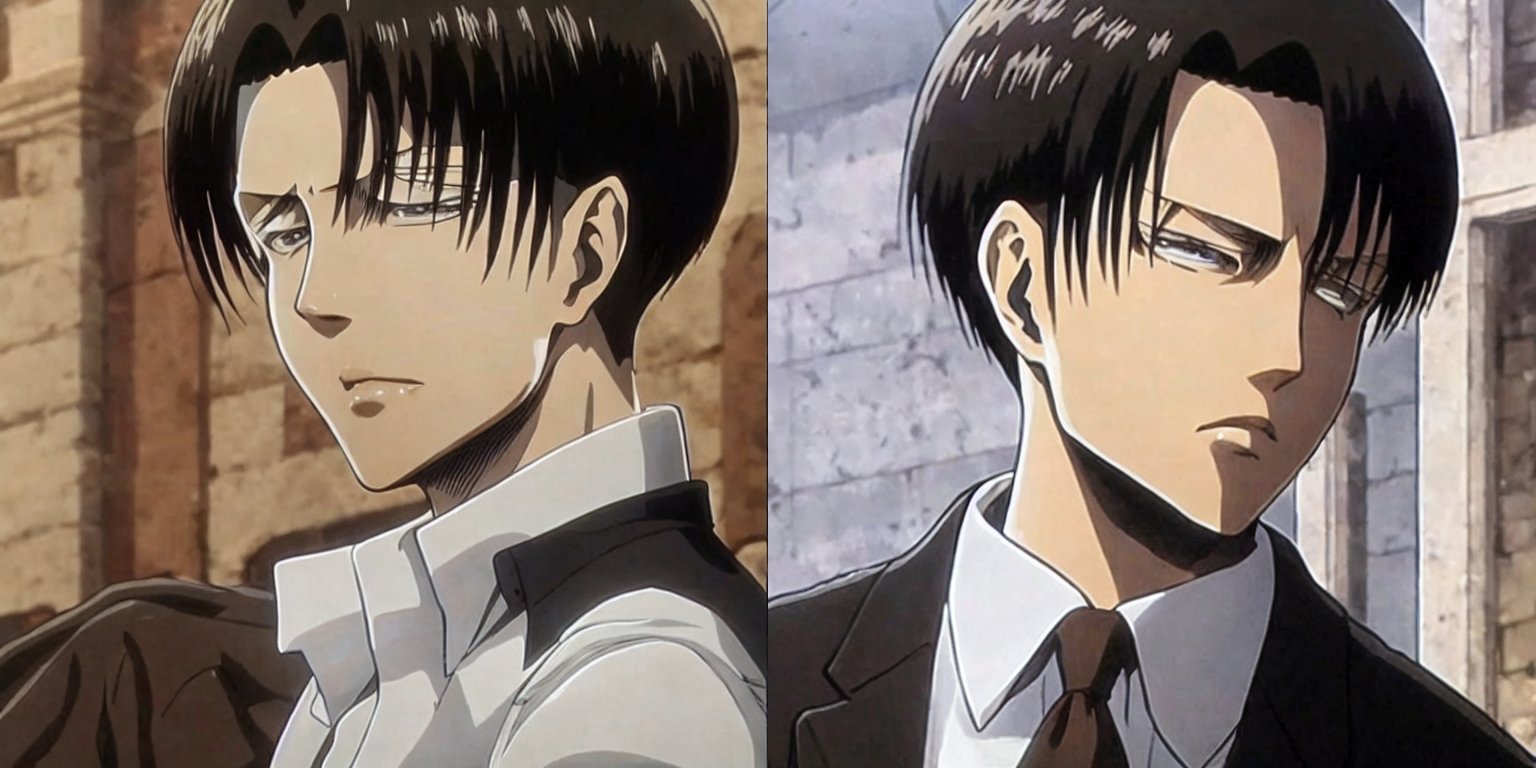


✅ Generation complete with Hires Fix!


In [2]:
import torch
import os
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
from PIL import Image
from IPython.display import display

CHECKPOINT_STEP = 600
OUTPUT_DIR = "/content/drive/MyDrive/my_first_lora_output_v5"

LORA_SCALE = 0.9
NUM_IMAGES = 2
GUIDANCE_SCALE = 7.0
INFERENCE_STEPS = 30

ENABLE_HIRES_FIX = True
HIRES_STRENGTH = 0.35
UPSCALE_FACTOR = 1.5

model_folder = os.path.join(OUTPUT_DIR, f"checkpoint-{CHECKPOINT_STEP}")

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False
).to("cuda")

pipe.load_lora_weights(model_folder, weight_name="pytorch_lora_weights.safetensors")

refiner = StableDiffusionImg2ImgPipeline(**pipe.components)

def image_grid(imgs, rows, cols):
    w, h = imgs[0].size
    grid = Image.new('RGB', (cols*w, rows*h))
    for i, img in enumerate(imgs):
        grid.paste(img, (i%cols*w, i//cols*h))
    return grid

prompt = (
"levi_training_model, black hair, undercut, gray eyes, male focus, black suit, white shirt, formal wear, looking at viewer, sitting, view from side, serious, highly detailed eyes, sharp focus"
)

neg_prompt = (
    "shiny eyes, glossy eyes, wet eyes, reflective eyes, eye shine, "
    "bad anatomy, poorly drawn eyes, ugly eyes, lowres, blurry, bad quality"
)

print(f"\nGenerating Base Images...")


base_images = pipe(
    prompt,
    negative_prompt=neg_prompt,
    num_inference_steps=INFERENCE_STEPS,
    guidance_scale=GUIDANCE_SCALE,
    cross_attention_kwargs={"scale": LORA_SCALE},
    num_images_per_prompt=NUM_IMAGES,
    height=512, width=512
).images

final_images = base_images

if ENABLE_HIRES_FIX:
    print(f"Running Hires")
    hires_images = []

    for img in base_images:
        w, h = img.size
        new_w, new_h = int(w * UPSCALE_FACTOR), int(h * UPSCALE_FACTOR)
        upscaled_img = img.resize((new_w, new_h), resample=Image.LANCZOS)

        refined_img = refiner(
            prompt=prompt,
            negative_prompt=neg_prompt,
            image=upscaled_img,
            num_inference_steps=30,
            strength=HIRES_STRENGTH,
            guidance_scale=GUIDANCE_SCALE,
            cross_attention_kwargs={"scale": LORA_SCALE}
        ).images[0]
        hires_images.append(refined_img)

    final_images = hires_images

grid = image_grid(final_images, rows=1, cols=NUM_IMAGES)
display(grid)

print("\nGeneration complete!")